In [86]:
# Import the libraries
import csv
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import os
from dotenv import load_dotenv
import datetime
from datetime import datetime
from datetime import date
from datetime import timedelta
import requests
import json

import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
import panel as pn
from panel.interact import interact
from panel import widgets
import numpy as np

from scipy.optimize import minimize

%matplotlib inline

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')


import yfinance as yf
from pandas_datareader import data as pdr
from pandas.testing import assert_frame_equal
from pandas.util.testing import assert_frame_equal
import pandas_datareader.data as web


import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


### Function get_user_transaction_data
* Input: 
    * None
* User Input:
    * Portfolio CSV File containing buy/sell transaction history
* Output: 
    * trans_df: Transacation dataframe

In [87]:
''' 
1. Read input csv

Assuming input includes following table structure:

Date: Purchased or Sold Date
Ticker: Ticker Symbol
Transaction: "B" for Buy, "S" for Sell
Transaction Price: Price of Purchase or Sold Shares, No $signs, No commas
Number of shares: Quantity of Purchased or Sold Shares, No commas

'''

def get_user_transaction_data ():
    
    input_file_path = input("Please enter input file name")    
    portfolio_csv = Path(input_file_path)
    trans_df = pd.read_csv(portfolio_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
    trans_df.sort_index(inplace=True)
    trans_df["Transaction Cost"]=trans_df["Transaction Price"].astype(float)*trans_df["Number of shares"].astype(float)
      
    return trans_df

In [88]:
trans_df = get_user_transaction_data()
trans_df

Please enter input file name TestPortfolio2a.csv


,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
Date,,,,,
2015-03-26,AMBA,B,67.90,70,4753.00
2018-01-29,AMBA,S,48.51,70,3395.70
2018-01-29,ALSN,B,39.26,130,5103.80
2018-01-29,CVS,B,82.00,60,4920.00
2018-01-29,ABBV,B,121.37,40,4854.80
2018-01-29,AMCX,B,52.99,100,5299.00
2018-02-28,G,B,31.90,155,4944.50
2018-02-28,ABMD,B,270.52,20,5410.40
2018-02-28,BIDU,B,251.34,20,5026.80


### Function calc_basic_transaction_data
* Input: 
    * trans_df: Transacation dataframe
* User Input:
    * None
* Output: 
    * portfolio_df: Expanded Transaction Dataframe

In [89]:
''' 
Assuming input includes following table structure:

Date: Purchased or Sold Date
Ticker: Ticker Symbol
Transaction: "B" for Buy, "S" for Sell
Transaction Price: Price of Purchase or Sold Shares, No $signs, No commas
Number of shares: Quantity of Purchased or Sold Shares, No commas

* Additional Columns calculated in code:

Transaction Cost: Transaction Price * Number of Shares
Cumulative Shares: All buys - all sells (upto the current date)
Avg Price per Share: Total transaction cost of cumulative shares / total cumulative shares
Cumulative Contributions: Avg Price per Share * Cumulative Shares

** Columns that need to be added after merging with daily closing prices:

Daily Balance: Cumulative Shares * Close
Unrealized Gains(Losses): Daily Balance - Cumulative Contributions

'''

def calc_basic_transaction_data (portfolio_df):
    # Make Sales (S) negative number of shares

    portfolio_df["Number of shares"] = portfolio_df.apply(lambda row: row["Number of shares"] if row["Transaction"] == "B" else row["Number of shares"] * -1, axis=1)

    # Create new column "Transaction Cost" showing cost of Buys (Buy price * Number of shares)

    portfolio_df["Transaction Cost"]=np.where((portfolio_df["Number of shares"] > 0), portfolio_df["Transaction Price"]*portfolio_df["Number of shares"],0)

    # Create new column "Proceeds" reflecting proceeds from Sale of Stock (Sell price * Number of shares)

    portfolio_df["Proceeds"] = np.where((portfolio_df["Number of shares"] < 0), portfolio_df["Transaction Price"]*portfolio_df["Number of shares"]*-1, 0)

    # Create new column "Cumulative Shares" to reflect shares owned

    portfolio_df["Cumulative Shares"] = portfolio_df[["Number of shares", "Ticker"]].groupby("Ticker").cumsum()

    '''Create Temporary Columns to calculate Avg Price per Share & Cumulative Contributions'''

    portfolio_df = portfolio_df.sort_values(by=["Ticker", "Date"])

    # Create TEMP column "Cumulative Cost Temp1"

    portfolio_df["Cumulative Cost Temp1"] = portfolio_df[["Transaction Cost", "Ticker"]].groupby("Ticker").cumsum()

    # Create TEMP column ""Avg Price per Share Temp1"

    portfolio_df["Avg Price per Share Temp1"] = portfolio_df.apply(lambda x: x["Cumulative Cost Temp1"] / x["Cumulative Shares"] if x["Transaction"]=="B" else 0, axis=1)

    # Create TEMP column ""Avg Price per Share Temp2"

    portfolio_df["Avg Price per Share Temp2"] = np.where(portfolio_df["Avg Price per Share Temp1"] > 0, portfolio_df["Avg Price per Share Temp1"], portfolio_df["Avg Price per Share Temp1"].shift(1))

    portfolio_df.reset_index(inplace=True)

    # Replace 0s in "Transaction Cost" where Sale has occured 
    portfolio_df.loc[portfolio_df["Transaction"] == "S", "Transaction Cost"] = portfolio_df["Avg Price per Share Temp2"] * portfolio_df["Number of shares"]

    # Create new column "Cumulative Cost"

    portfolio_df["Cumulative Contributions"] = portfolio_df[["Transaction Cost", "Ticker"]].groupby("Ticker").cumsum()

    # Create new column "Avg Price per Share"
    portfolio_df["Avg Price per Share"] = portfolio_df["Cumulative Contributions"] / portfolio_df["Cumulative Shares"]

    # Remove TEMP columns

    portfolio_df.drop(["Cumulative Cost Temp1", "Avg Price per Share Temp1", "Avg Price per Share Temp2"], inplace=True, axis=1)

    # Final dataframe ready to merge

    portfolio_df.sort_index(inplace=True)
    
    return portfolio_df

In [90]:
portfolio_df = calc_basic_transaction_data(trans_df[:-1].copy())
portfolio_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Proceeds,Cumulative Shares,Cumulative Contributions,Avg Price per Share
0,2018-01-29,ABBV,B,121.37,40,4854.80,0.0,40,4854.80,121.370000
1,2018-05-29,ABBV,B,100.20,50,5010.00,0.0,90,9864.80,109.608889
2,2018-02-28,ABMD,B,270.52,20,5410.40,0.0,20,5410.40,270.520000
3,2018-05-29,ADBE,B,242.77,20,4855.40,0.0,20,4855.40,242.770000
4,2018-01-29,ALSN,B,39.26,130,5103.80,0.0,130,5103.80,39.260000
5,2015-03-26,AMBA,B,67.90,70,4753.00,0.0,70,4753.00,67.900000
6,2018-01-29,AMBA,S,48.51,-70,-4753.00,3395.7,0,0.00,NaN
7,2018-01-29,AMCX,B,52.99,100,5299.00,0.0,100,5299.00,52.990000
8,2018-02-28,BIDU,B,251.34,20,5026.80,0.0,20,5026.80,251.340000
9,2018-01-29,CVS,B,82.00,60,4920.00,0.0,60,4920.00,82.000000


In [91]:
trans_df

,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
Date,,,,,
2015-03-26,AMBA,B,67.90,70,4753.00
2018-01-29,AMBA,S,48.51,70,3395.70
2018-01-29,ALSN,B,39.26,130,5103.80
2018-01-29,CVS,B,82.00,60,4920.00
2018-01-29,ABBV,B,121.37,40,4854.80
2018-01-29,AMCX,B,52.99,100,5299.00
2018-02-28,G,B,31.90,155,4944.50
2018-02-28,ABMD,B,270.52,20,5410.40
2018-02-28,BIDU,B,251.34,20,5026.80


### Function pull_stock_data
* Input: 
    * portfolio_df: Expanded Transaction Dataframe
    * date: from datetime
* User Input:
    * None
* Ouputs:
    * ticker_stats_df_T
    * closing_df
    * portfolio4_df: merged portfolio_df with closing data
    * min_stock_dates
    * yesterday

In [92]:
def pull_stock_data (portfolio_df, date):
    '''
    Set parameters and variables from portfolio_df dataframe.
    '''

    # Determine unique stocks

    group=portfolio_df.groupby('Ticker')

    # Store unique stocks to stock list

    group.groups.keys()
    stock_list=list(group.groups)

    # Find the min dates per ticker

    portfolio2_df=portfolio_df.reset_index()
    min_stock_dates=portfolio2_df.groupby('Ticker')["Date"].min().to_dict()

    # Store yesterday's date

    yesterday = date.today() - timedelta(days=1)
    yesterday = yesterday.strftime("%Y-%m-%d")

    '''
    Pull Closing Prices AND Stats Info yfinance
    '''

    yf.pdr_override() 

    ticker_list_df  = pd.DataFrame(stock_list)
    ticker_list = list(ticker_list_df[0].values)
    tickers = []
    price = pd.DataFrame()
    ticker_stats = pd.DataFrame()
    ticker_stats_df = pd.DataFrame()

    for ticker_name, date in min_stock_dates.items():
        tickers.append(ticker_name)
        ticker = yf.Ticker(ticker_name)
        data = pdr.get_data_yahoo(ticker_name, start=date, end=yesterday)
        data["Ticker"]=ticker_name
        price=price.append(data)

        stats = ticker.info
        for x in stats.items():

            symbol = stats["symbol"]
#             trailing_pe = stats["trailingPE"]
            profit_margin = stats["profitMargins"]
            beta = stats["beta"]
            dividend_yield = stats["dividendYield"]
            industry = stats["industry"]
            sector = stats["sector"]
            exchange = stats["exchange"]



            ticker_stats["Ticker"] = symbol
#             ticker_stats["Trailing PE"] = trailing_pe
            ticker_stats["Profit Margin"] = profit_margin
            ticker_stats["Beta"] = 0 if beta is None else beta
            ticker_stats["Dividend Yield"] = 0 if dividend_yield is None else dividend_yield
            ticker_stats["Industry"] = industry
            ticker_stats["Sector"] = sector
            ticker_stats["Exchange"] = exchange
            ticker_stats["X"] = x

        ticker_stats_df=ticker_stats_df.append(ticker_stats)
        ticker_stats_df.drop(["X"], inplace=True, axis=1)
        ticker_stats_df.drop_duplicates(inplace=True)
        
        
    # Create ticker_stats_df_T

    ticker_stats_df_T = ticker_stats_df.copy()
    ticker_stats_df_T.reset_index(drop=True, inplace=True)

###
    # Create closing_price_df

    closing_price_df = price[["Ticker", "Adj Close"]].copy()
    closing_price_df = closing_price_df.rename(columns={"Adj Close": "Close"})
    closing_price_df.reset_index(inplace=True)
    closing_price_df.sort_values(by=["Date", "Ticker"], inplace=True)
    
    # Create closing_df

    closing_df = closing_price_df.pivot(index="Date", columns="Ticker", values="Close")
    
###    
    '''
    1. Merge portfolio_df with closing_price_df
    '''
    portfolio3_df = pd.merge(portfolio_df, closing_price_df, how='right', left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])


    '''
    2. Fill in gaps in Cumulative Shares, Cumulative Contributions, and Avg Price Per Share
    '''
    temp1 = portfolio3_df.copy()
    temp1.reset_index(drop=True, inplace = True)
    temp2 = temp1.groupby(['Ticker','Date']).agg({'Cumulative Shares': "mean", "Cumulative Contributions": "mean", "Avg Price per Share": "mean"}).fillna(method='ffill')

    portfolio4_df = temp1.sort_values(['Ticker','Date'], ascending = (True, True))
    portfolio4_df['Cumulative Shares'] = [x for x in temp2['Cumulative Shares']]
    portfolio4_df['Cumulative Contributions'] = [x for x in temp2['Cumulative Contributions']]
    portfolio4_df['Avg Price per Share'] = [x for x in temp2['Avg Price per Share']]


    '''
    3. Add New Columns:
    -- Daily Balance: Cumulative Shares * Close
    -- Unrealized Gains(Losses): Daily Balance - Cumulative Contributions  
    '''
    portfolio4_df["Daily Balance"] = round(portfolio4_df["Cumulative Shares"] * portfolio4_df["Close"],2)
    portfolio4_df["Unrealized Gains(Losses)"] = round(portfolio4_df["Daily Balance"] - portfolio4_df["Cumulative Contributions"],2)

    portfolio4_df.reset_index(drop=True, inplace=True)
    portfolio4_df.sort_values(by=["Date", "Ticker"], inplace=True)

    return ticker_stats_df_T, closing_df, portfolio4_df, min_stock_dates, yesterday,stock_list

In [93]:
ticker_stats_df_T, closing_df, portfolio4_df, min_stock_dates, yesterday,stock_list = pull_stock_data(portfolio_df, date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed


C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed


C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed


C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed


C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




C:\Python\COnda\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [94]:
ticker_stats_df_T

,Beta,Dividend Yield,Exchange,Industry,Profit Margin,Sector,Ticker
0,0.716833,0.0542,NYQ,Drug Manufacturers—General,0.19204,Healthcare,ABBV
1,1.142697,0.0000,NMS,Medical Devices,0.19882,Healthcare,ABMD
2,0.942028,0.0000,NMS,Software—Infrastructure,0.31050,Technology,ADBE
3,1.272017,0.0196,NYQ,Auto Parts,0.18174,Consumer Cyclical,ALSN
4,1.204570,0.0000,NMS,Semiconductor Equipment & Materials,-0.20666,Technology,AMBA
5,0.882385,0.0000,NMS,Broadcasting,0.06655,Communication Services,AMCX
6,1.380713,0.0000,NMS,Internet Content & Information,0.03403,Communication Services,BIDU
7,0.654403,0.0346,NYQ,Healthcare Plans,0.03140,Healthcare,CVS
8,1.188405,0.0100,NYQ,Information Technology Services,0.08710,Technology,G
9,1.411371,0.0033,NMS,Semiconductor Equipment & Materials,0.27703,Technology,OLED


In [95]:
closing_df.head()

Ticker,ABBV,ABMD,ADBE,ALSN,AMBA,AMCX,BIDU,CVS,G,OLED
Date,,,,,,,,,,
2015-03-26,NaN,NaN,NaN,NaN,68.510002,NaN,NaN,NaN,NaN,NaN
2015-03-27,NaN,NaN,NaN,NaN,70.349998,NaN,NaN,NaN,NaN,NaN
2015-03-30,NaN,NaN,NaN,NaN,74.610001,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,75.709999,NaN,NaN,NaN,NaN,NaN
2015-04-01,NaN,NaN,NaN,NaN,73.970001,NaN,NaN,NaN,NaN,NaN


In [96]:
closing_df.tail()

Ticker,ABBV,ABMD,ADBE,ALSN,AMBA,AMCX,BIDU,CVS,G,OLED
Date,,,,,,,,,,
2020-09-28,87.279999,273.549988,488.510010,34.950001,51.970001,24.719999,126.040001,57.939999,38.980000,174.600006
2020-09-29,86.889999,272.459991,489.329987,34.860001,52.020000,24.600000,122.580002,57.540001,38.680000,178.880005
2020-09-30,87.589996,277.059998,490.429993,35.139999,52.180000,24.709999,126.589996,58.400002,38.950001,180.740005
2020-10-01,87.139999,260.450012,499.510010,34.639999,53.630001,24.260000,126.449997,57.840000,38.740002,183.559998
2020-10-02,86.120003,261.989990,478.989990,34.919998,51.919998,24.049999,124.620003,57.830002,38.570000,179.429993


In [97]:
portfolio4_df.head()

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Proceeds,Cumulative Shares,Cumulative Contributions,Avg Price per Share,Close,Daily Balance,Unrealized Gains(Losses)
2600,2015-03-26,AMBA,B,67.9,70.0,4753.0,0.0,70.0,4753.0,67.9,68.510002,4795.7,42.7
2601,2015-03-27,AMBA,NaN,NaN,NaN,NaN,NaN,70.0,4753.0,67.9,70.349998,4924.5,171.5
2602,2015-03-30,AMBA,NaN,NaN,NaN,NaN,NaN,70.0,4753.0,67.9,74.610001,5222.7,469.7
2603,2015-03-31,AMBA,NaN,NaN,NaN,NaN,NaN,70.0,4753.0,67.9,75.709999,5299.7,546.7
2604,2015-04-01,AMBA,NaN,NaN,NaN,NaN,NaN,70.0,4753.0,67.9,73.970001,5177.9,424.9


In [98]:
portfolio4_df.tail()

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Proceeds,Cumulative Shares,Cumulative Contributions,Avg Price per Share,Close,Daily Balance,Unrealized Gains(Losses)
4667,2020-10-02,AMCX,NaN,NaN,NaN,NaN,NaN,100.0,5299.0,52.990000,24.049999,2405.00,-2894.00
5322,2020-10-02,BIDU,NaN,NaN,NaN,NaN,NaN,20.0,5026.8,251.340000,124.620003,2492.40,-2534.40
5998,2020-10-02,CVS,NaN,NaN,NaN,NaN,NaN,95.0,7209.7,75.891579,57.830002,5493.85,-1715.85
6653,2020-10-02,G,NaN,NaN,NaN,NaN,NaN,155.0,4944.5,31.900000,38.570000,5978.35,1033.85
7124,2020-10-02,OLED,NaN,NaN,NaN,NaN,NaN,155.0,4944.5,31.900000,179.429993,27811.65,22867.15


In [99]:
min_stock_dates

{'ABBV': Timestamp('2018-01-29 00:00:00'),
 'ABMD': Timestamp('2018-02-28 00:00:00'),
 'ADBE': Timestamp('2018-05-29 00:00:00'),
 'ALSN': Timestamp('2018-01-29 00:00:00'),
 'AMBA': Timestamp('2015-03-26 00:00:00'),
 'AMCX': Timestamp('2018-01-29 00:00:00'),
 'BIDU': Timestamp('2018-02-28 00:00:00'),
 'CVS': Timestamp('2018-01-29 00:00:00'),
 'G': Timestamp('2018-02-28 00:00:00'),
 'OLED': Timestamp('2018-11-18 00:00:00')}

In [100]:
yesterday

'2020-10-03'

### Function portfolio_analysis
* Input:
    * portfolio4_df
    * min_stock_dates
    * yesterday
* User Input:
    * None
* Output:
    * portfolio_df_returns4
    * portfolio_df_returns2
    * value

In [101]:
def portfolio_analysis (portfolio4_df, min_stock_dates, yesterday):
    # sp500_stats = yf.Ticker("^GSPC")
    sp500 = pdr.get_data_yahoo("^GSPC", start=min(min_stock_dates.values()), end=yesterday)
    # nasdaq_stats = yf.Ticker("^IXIC")
    nasdaq = pdr.get_data_yahoo("^IXIC", start=min(min_stock_dates.values()), end=yesterday)
    
    sp500 = sp500[["Adj Close"]].copy()
    sp500 = sp500.rename(columns={"Adj Close": "S&P 500"})

    nasdaq = nasdaq[["Adj Close"]].copy()
    nasdaq = nasdaq.rename(columns={"Adj Close": "Nasdaq"})

    contributions = portfolio4_df[["Date", "Ticker","Cumulative Contributions"]].copy().reset_index(drop=True)
    contributions= contributions.pivot(index="Date", columns="Ticker", values="Cumulative Contributions")
    contributions=contributions.add_suffix(" Cost")
    contributions["Total Contributions"]=contributions.sum(axis = 1, skipna = True)

    value = portfolio4_df[["Date", "Ticker","Daily Balance"]].copy().reset_index(drop=True)
    value=value.pivot(index="Date", columns="Ticker", values="Daily Balance")
    value=value.add_suffix(" Value")
    value["Total Portfolio Value"]=value.sum(axis = 1, skipna = True)

    portfolio_df_returns = contributions.merge(value.merge(sp500.merge(nasdaq, on="Date"), on="Date"), on="Date")

    
    # Create Returns2 with pct_change

    portfolio_df_returns2 = value.merge(sp500.merge(nasdaq, on="Date"), on="Date")
    portfolio_df_returns2 = portfolio_df_returns2.pct_change().fillna(0)
    portfolio_df_returns2 = portfolio_df_returns2.iloc[1:]
    
    # Create Returns3 with only Total Portfolio & S&P 500

    portfolio_df_returns3 = portfolio_df_returns[portfolio_df_returns.columns[-3:]].copy()
    
    # Create Returns4 with pct_change

    portfolio_df_returns4 = portfolio_df_returns2[portfolio_df_returns2.columns[-3:]].copy()
    
    return portfolio_df_returns4, portfolio_df_returns2, value

In [102]:
portfolio_df_returns4, portfolio_df_returns2, value = portfolio_analysis(portfolio4_df, min_stock_dates, yesterday)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [103]:
portfolio_df_returns4.head()

,Total Portfolio Value,S&P 500,Nasdaq
Date,,,
2015-03-27,0.026857,0.002369,0.005729
2015-03-30,0.060554,0.012237,0.011494
2015-03-31,0.014743,-0.008796,-0.009411
2015-04-01,-0.022982,-0.003965,-0.004214
2015-04-02,0.000406,0.003530,0.001375


In [104]:
portfolio_df_returns4.tail()

,Total Portfolio Value,S&P 500,Nasdaq
Date,,,
2020-09-28,0.017432,0.016111,0.018690
2020-09-29,0.006253,-0.004813,-0.002904
2020-09-30,0.009994,0.008254,0.007421
2020-10-01,0.000655,0.005293,0.014238
2020-10-02,-0.016011,-0.009578,-0.022204


In [105]:
portfolio_df_returns2.head()

,ABBV Value,ABMD Value,ADBE Value,ALSN Value,AMBA Value,AMCX Value,BIDU Value,CVS Value,G Value,OLED Value,Total Portfolio Value,S&P 500,Nasdaq
Date,,,,,,,,,,,,,
2015-03-27,0.0,0.0,0.0,0.0,0.026857,0.0,0.0,0.0,0.0,0.0,0.026857,0.002369,0.005729
2015-03-30,0.0,0.0,0.0,0.0,0.060554,0.0,0.0,0.0,0.0,0.0,0.060554,0.012237,0.011494
2015-03-31,0.0,0.0,0.0,0.0,0.014743,0.0,0.0,0.0,0.0,0.0,0.014743,-0.008796,-0.009411
2015-04-01,0.0,0.0,0.0,0.0,-0.022982,0.0,0.0,0.0,0.0,0.0,-0.022982,-0.003965,-0.004214
2015-04-02,0.0,0.0,0.0,0.0,0.000406,0.0,0.0,0.0,0.0,0.0,0.000406,0.003530,0.001375


In [106]:
portfolio_df_returns2.tail()

,ABBV Value,ABMD Value,ADBE Value,ALSN Value,AMBA Value,AMCX Value,BIDU Value,CVS Value,G Value,OLED Value,Total Portfolio Value,S&P 500,Nasdaq
Date,,,,,,,,,,,,,
2020-09-28,0.012177,0.026685,0.018196,0.031278,0.0,0.021910,0.018176,0.010816,0.022024,0.014409,0.017432,0.016111,0.018690
2020-09-29,-0.004468,-0.003985,0.001679,-0.002575,0.0,-0.004854,-0.027452,-0.006904,-0.007696,0.024513,0.006253,-0.004813,-0.002904
2020-09-30,0.008056,0.016883,0.002248,0.008032,0.0,0.004472,0.032713,0.014946,0.006980,0.010398,0.009994,0.008254,0.007421
2020-10-01,-0.005138,-0.059951,0.018514,-0.014229,0.0,-0.018211,-0.001106,-0.009589,-0.005392,0.015603,0.000655,0.005293,0.014238
2020-10-02,-0.011705,0.005913,-0.041080,0.008083,0.0,-0.008656,-0.014472,-0.000173,-0.004388,-0.022499,-0.016011,-0.009578,-0.022204


In [107]:
value.head()

Ticker,ABBV Value,ABMD Value,ADBE Value,ALSN Value,AMBA Value,AMCX Value,BIDU Value,CVS Value,G Value,OLED Value,Total Portfolio Value
Date,,,,,,,,,,,
2015-03-26,NaN,NaN,NaN,NaN,4795.7,NaN,NaN,NaN,NaN,NaN,4795.7
2015-03-27,NaN,NaN,NaN,NaN,4924.5,NaN,NaN,NaN,NaN,NaN,4924.5
2015-03-30,NaN,NaN,NaN,NaN,5222.7,NaN,NaN,NaN,NaN,NaN,5222.7
2015-03-31,NaN,NaN,NaN,NaN,5299.7,NaN,NaN,NaN,NaN,NaN,5299.7
2015-04-01,NaN,NaN,NaN,NaN,5177.9,NaN,NaN,NaN,NaN,NaN,5177.9


In [108]:
value.tail()

Ticker,ABBV Value,ABMD Value,ADBE Value,ALSN Value,AMBA Value,AMCX Value,BIDU Value,CVS Value,G Value,OLED Value,Total Portfolio Value
Date,,,,,,,,,,,
2020-09-28,7855.2,5471.0,9770.2,4543.5,0.0,2472.0,2520.8,5504.30,6041.90,27063.00,71241.90
2020-09-29,7820.1,5449.2,9786.6,4531.8,0.0,2460.0,2451.6,5466.30,5995.40,27726.40,71687.40
2020-09-30,7883.1,5541.2,9808.6,4568.2,0.0,2471.0,2531.8,5548.00,6037.25,28014.70,72403.85
2020-10-01,7842.6,5209.0,9990.2,4503.2,0.0,2426.0,2529.0,5494.80,6004.70,28451.80,72451.30
2020-10-02,7750.8,5239.8,9579.8,4539.6,0.0,2405.0,2492.4,5493.85,5978.35,27811.65,71291.25


# Pie Charts

In [109]:
'''
Holdings, Industry and Sector Pie Charts

'''

# Define last closing price date

max_date=portfolio4_df["Date"].max()

# Create dataframe with Current Values for Cumulative Shares, Daily Balance, and Cumulative Contributions

holdings_df=portfolio4_df[portfolio4_df.Date == max_date].copy().reset_index(drop=True)
holdings_df=holdings_df[["Ticker", "Cumulative Shares","Cumulative Contributions", "Daily Balance"]]

# Create dataframe with Industry & Sector information by Ticker

sector_df=ticker_stats_df_T[["Ticker","Industry", "Sector"]].copy().reset_index(drop=True)
sector_df.rename(columns={"index":"Ticker"}, inplace=True)

# Create dataframe with Current Values and Industry/Sector information by Ticker

current_industry_holdings = pd.merge(holdings_df, sector_df, on="Ticker")

# Create dataframe for Industry holdings

industry_holdings = current_industry_holdings.groupby("Industry").sum()
industry_holdings.reset_index(inplace=True)

# Create new dataframe for Sector holdings

sector_holdings= current_industry_holdings.groupby("Sector").sum()
sector_holdings.reset_index(inplace=True)

# # FOR PANEL DASHBOARD 

# holdings_contribution_pie=px.pie(current_industry_holdings, values="Cumulative Contributions", names="Ticker", title="Contributions by Stock")
# holdings_value_pie=px.pie(current_industry_holdings, values="Daily Balance", names="Ticker", title="Current Value by Stock")

# industry_contribution_pie=px.pie(industry_holdings, values="Cumulative Contributions", names="Industry", title="Contributions by Industry")
# industry_value_pie=px.pie(industry_holdings, values="Daily Balance", names="Industry", title="Current Value by Industry")


# sector_contribution_pie=px.pie(sector_holdings, values="Cumulative Contributions", names="Sector", title="Contributions by Sector")
# sector_value_pie=px.pie(sector_holdings, values="Daily Balance", names="Sector", title="Current Value by Sector")


### Function holdings_contribution_pie
* Input:
    * current_industry_holdings
* Output
    * Returns interactive pie chart

In [110]:
# Create Pie Chart for Contributions by Stock

def holdings_contribution_pie(df):
    return px.pie(
        df, 
        values="Cumulative Contributions", 
        names="Ticker", 
        title="Contributions by Stock")


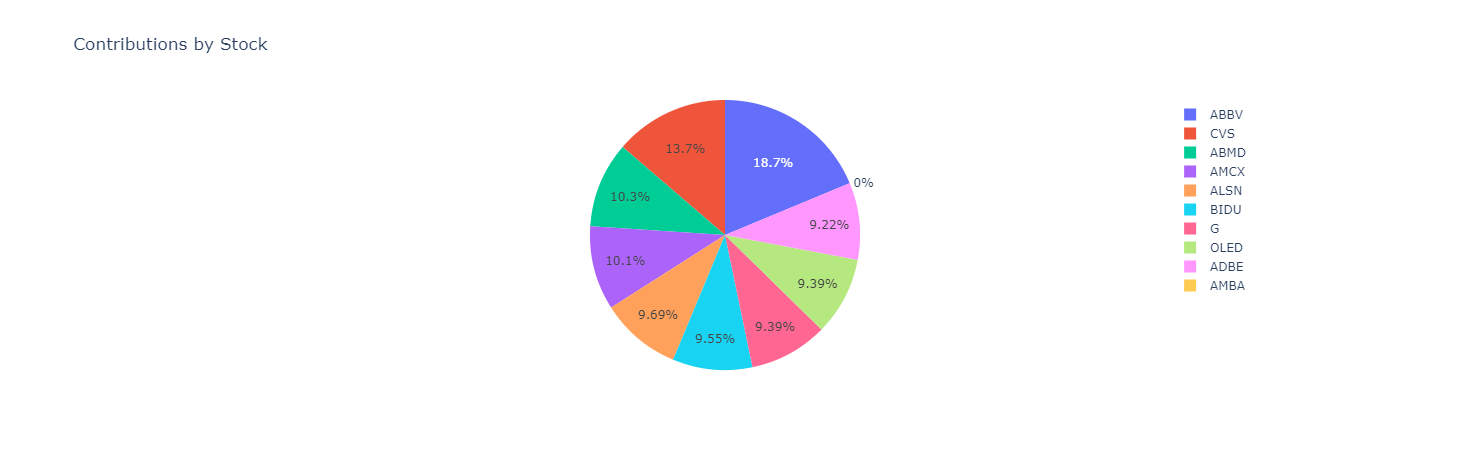

In [111]:
holdings_contribution_pie(current_industry_holdings)

### Function holdings_value_pie
* Input:
    * current_industry_holdings
* Output
    * Returns interactive pie chart

In [112]:
# Create Pie Chart for Current Value by Stock

def holdings_value_pie(df):
    return px.pie(
        df, 
        values="Daily Balance", 
        names="Ticker", 
        title="Current Value by Stock")


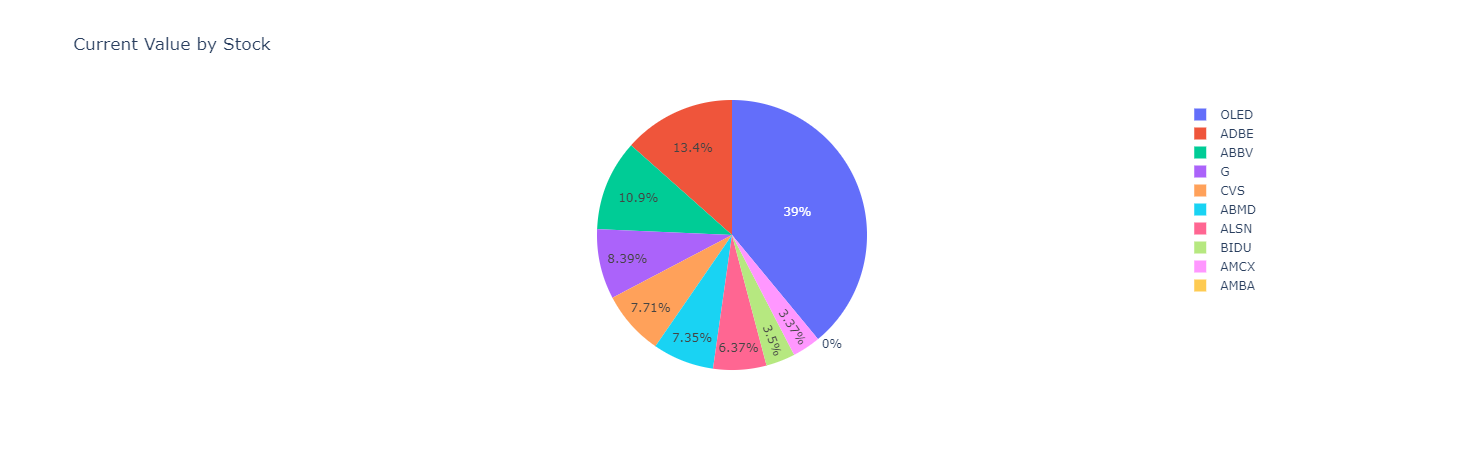

In [113]:
holdings_value_pie(current_industry_holdings)

### Function industry_contribution_pie
* Input:
    * industry_holdings
* Output
    * Returns interactive pie chart

In [114]:
# Create Pie Charts for Contributions by Industry

def industry_contribution_pie(df):
    return px.pie(
        df, 
        values="Cumulative Contributions", 
        names="Industry", 
        title="Contributions by Industry")


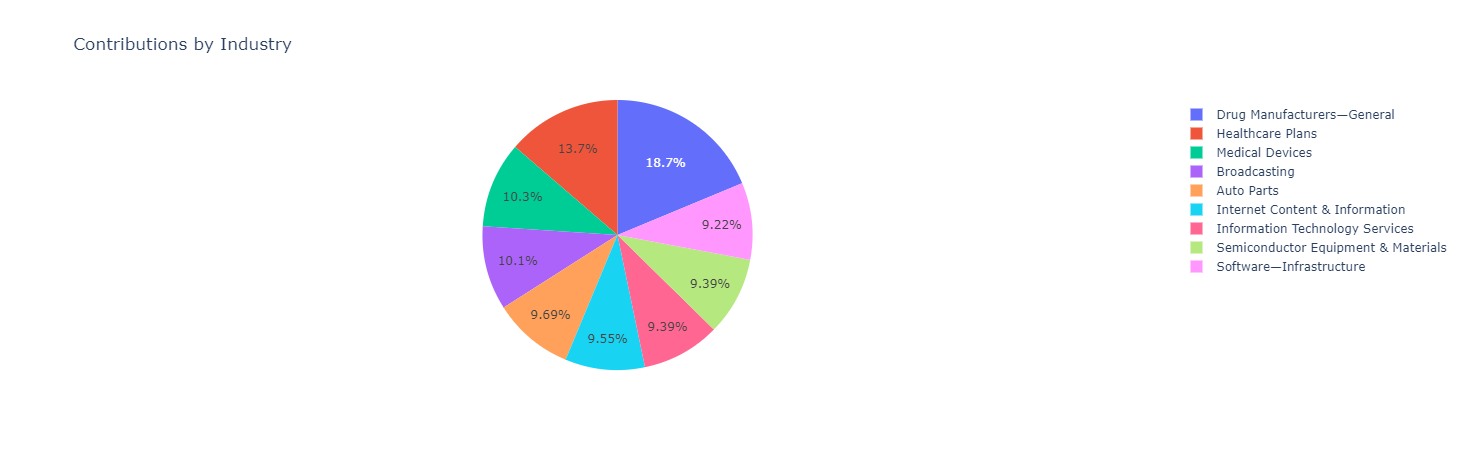

In [115]:
industry_contribution_pie(industry_holdings)

### Function industry_value_pie
* Input:
    * industry_holdings
* Output
    * Returns interactive pie chart

In [116]:
# Create Pie Charts for Current Value by Industry

def industry_value_pie(df):
    return px.pie(
        df, 
        values="Daily Balance", 
        names="Industry", 
        title="Current Value by Industry")


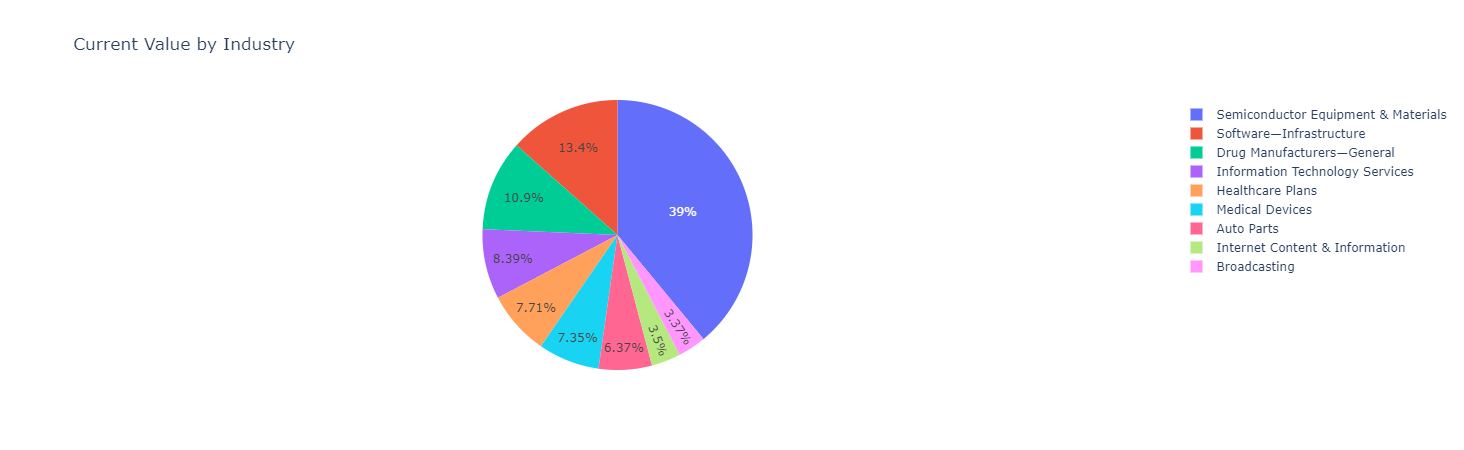

In [117]:
industry_value_pie(industry_holdings)

### Function sector_contribution_pie
* Input:
    * sector_holdings
* Output
    * Returns interactive pie chart

In [118]:
# Create Pie Charts for Contributions by Sector

def sector_contribution_pie(df):
    return px.pie(
        df,
        values="Cumulative Contributions", 
        names="Sector", 
        title="Contributions by Sector")


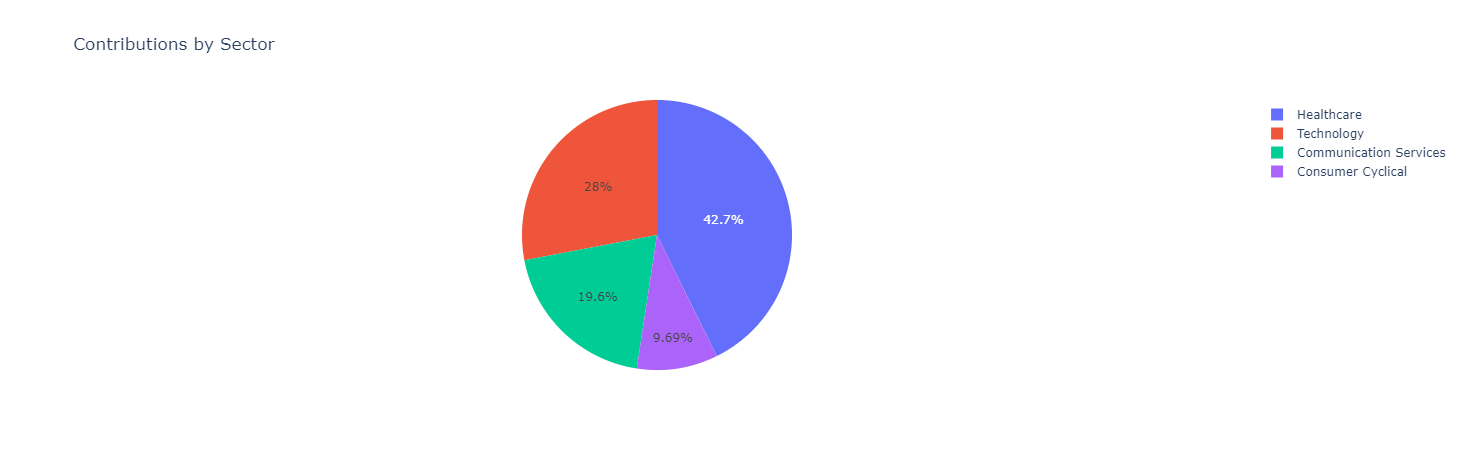

In [119]:
sector_contribution_pie(sector_holdings)

### Function sector_value_pie
* Input:
    * sector_holdings
* Output
    * Returns interactive pie chart

In [120]:
# Create Pie Charts for Current Value by Sector

def sector_value_pie(df):
    return px.pie(
        df, 
        values="Daily Balance", 
        names="Sector", 
        title="Current Value by Sector")


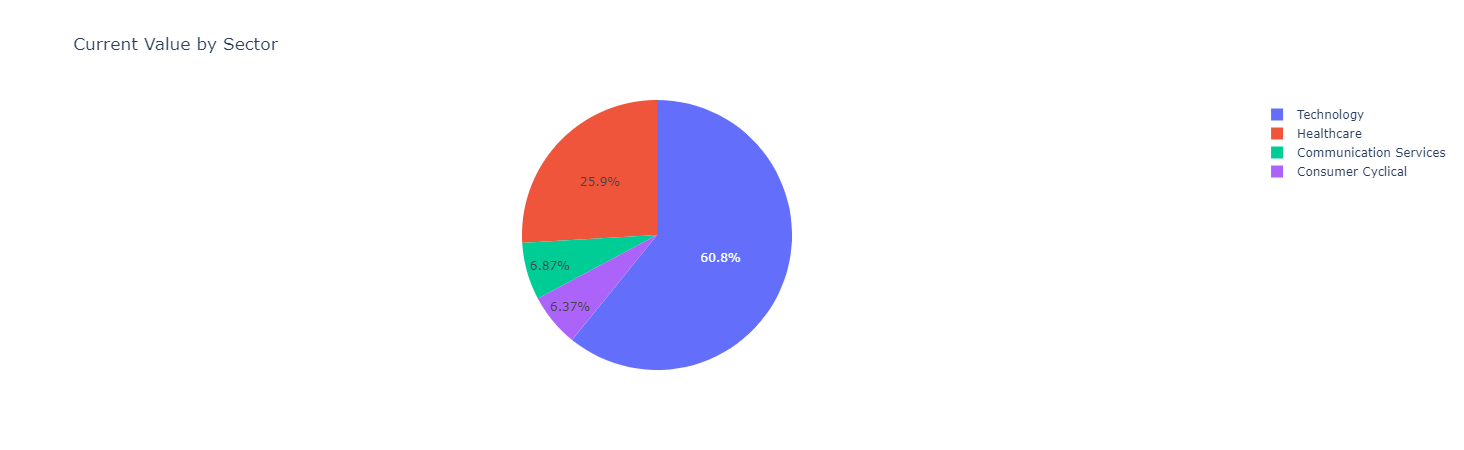

In [121]:
sector_value_pie(sector_holdings)

# Create Ticker Stats Panel
Using the portfolio database, determine the number of unique stocks and pull stock history.
* Inputs:
    * Transposed Ticker Stat Database (ticker_stats_df_T) (Tickers as Columns)
* Outputs:
    * Ticker Stat Panel (stats_panel)

In [122]:
# Define function that will change negative numbers to red text

def color_negative_red(value):
    if value < 0:
        color='red'
    else:
        color='black'
    return 'color: %s' % color

# Define function that will highlight the max value

def highlight_max(value):
    is_max = value == value.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [123]:
#Format ticker_stats_df_T to:
#   Highlight negative values red
#   Highlight largest value yellow
#   Add '$' and ',' to currency
#   Change percentages to %
#   Change floats to 2 decimal places

formatted_stats_df = ticker_stats_df_T.style.applymap(
    color_negative_red, subset=[
        'Beta', 
#         'Trailing PE',
        'Profit Margin']
    ).apply(
    highlight_max, subset=[
        'Beta', 
        'Dividend Yield', 
#         'Trailing PE', 
        'Profit Margin']
    ).format(
    {'Beta':'{:,.2f}', 
     'Dividend Yield':'{:,.1%}', 
#      'Trailing PE':'{:,.2f}', 
     'Profit Margin':'{:,.1%}'}
    )

formatted_stats_df

,Beta,Dividend Yield,Exchange,Industry,Profit Margin,Sector,Ticker
0,0.72,5.4%,NYQ,Drug Manufacturers—General,19.2%,Healthcare,ABBV
1,1.14,0.0%,NMS,Medical Devices,19.9%,Healthcare,ABMD
2,0.94,0.0%,NMS,Software—Infrastructure,31.1%,Technology,ADBE
3,1.27,2.0%,NYQ,Auto Parts,18.2%,Consumer Cyclical,ALSN
4,1.20,0.0%,NMS,Semiconductor Equipment & Materials,-20.7%,Technology,AMBA
5,0.88,0.0%,NMS,Broadcasting,6.7%,Communication Services,AMCX
6,1.38,0.0%,NMS,Internet Content & Information,3.4%,Communication Services,BIDU
7,0.65,3.5%,NYQ,Healthcare Plans,3.1%,Healthcare,CVS
8,1.19,1.0%,NYQ,Information Technology Services,8.7%,Technology,G
9,1.41,0.3%,NMS,Semiconductor Equipment & Materials,27.7%,Technology,OLED


In [124]:
# Create panel to show ticker data

stats_panel = pn.panel(formatted_stats_df)

stats_panel

HTML(Styler)

# Portfolio Optimization
Source code borrowed from [PrateekKumarSingh's GitHub](https://github.com/PrateekKumarSingh/Python/blob/master/Python%20for%20Finance/Python-for-Finance-Repo-master/09-Python-Finance-Fundamentals/02-Portfolio-Optimization.ipynb) and then updated for our purposes

### Function efficient_frontier
* Inputs:
    * closing_df
    * value
* User Inputs:
    * None
* Outputs:
    * log_return
    * weight_stock_index
    * portfolio_weights
    * portfolio_expected_returns
    * portfolio_expected_variance
    * portfolio_sharpe_ratio
    * best_sharpe_ratio
    * best_sharpe_ratio_weights
    * efficient_frontier_fig

In [125]:

# Use daily closing prices from above
stock_df = closing_df.copy()
stock_df.sort_values('Date', ascending=True, inplace=True)

###    
# Calculate the current portfolio weight
total_balance_temp = value[value.index == max_date]
total_balance = total_balance_temp["Total Portfolio Value"][0]

total_balance_temp.reset_index(drop=True, inplace=True)
total_balance_temp=list(total_balance_temp.loc[0])

portfolio_weight = [x/total_balance for x in total_balance_temp]
portfolio_weight = portfolio_weight[:-1]

###  
# Create Log Returns Dataframe
log_return = np.log(stock_df/stock_df.shift(1))

###
# Determine expected return and standard deviation for current portfolio weights
# Set seed
np.random.seed(13)

# Stock Columns
weight_stock_index = stock_df.columns

# Use the current portfolio weights
portfolio_weights=np.array(portfolio_weight)

# Expected Return
portfolio_expected_returns = np.sum(log_return.mean() * portfolio_weights) *252

# Expected Variance
portfolio_expected_variance = np.sqrt(np.dot(portfolio_weights.T, np.dot(log_return.cov() * 252, portfolio_weights)))

# Sharpe Ratio
portfolio_sharpe_ratio = portfolio_expected_returns/portfolio_expected_variance


###
# Run Monte Carlo
# Set the number of simulations
num_portfolios = 1000
num_stocks = len(stock_df.columns)

all_weights = np.zeros((num_portfolios,num_stocks))
expected_returns_arr = np.zeros(num_portfolios)
expected_variance_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for ind in range(num_portfolios):
    # Create Random Weights
    weights = np.array(np.random.random(num_stocks))

    # Rebalance Weights
    weights = weights / np.sum(weights)

    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    expected_returns_arr[ind] = np.sum((log_return.mean() * weights) *252)

    # Expected Variance
    expected_variance_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = expected_returns_arr[ind]/expected_variance_arr[ind]

# Determine the best sharpe ratio
best_sharpe_ratio = sharpe_arr.max()
# Determine the index of the max sharpe ratio
best_sharpe_index=sharpe_arr.argmax()
# Store weights of portfolio with the best sharpe ratio
best_sharpe_ratio_weights = all_weights[best_sharpe_index, :]
# Extract expected return of portfolio with the best sharpe ratio
best_return = expected_returns_arr[best_sharpe_index]
# Extract expected variance of portfolio with the best sharpe ratio
best_variance = expected_variance_arr[best_sharpe_index]

# Determine the index of the least volatility
least_volatile_index=expected_variance_arr.argmin()
#Extract expected return of portfolio with the least volatility
min_return = expected_returns_arr[least_volatile_index]

#return total_balance, log_return, weight_stock_index, portfolio_weights, portfolio_expected_returns, portfolio_expected_variance, portfolio_sharpe_ratio, best_sharpe_ratio, best_sharpe_ratio_weights, efficient_frontier_fig



## Green Line code start

0.15633222022953974

In [126]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol =np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [127]:
from scipy.optimize import minimize

In [128]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [129]:
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [130]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0,1),)*num_stocks
init_guess = []
for guess in range(num_stocks):
    init_guess.append(1/num_stocks)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [131]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
lwr_bnd=expected_returns_arr.min()
upr_bnd=expected_returns_arr.max()
frontier_y = np.linspace(lwr_bnd,upr_bnd,100)

In [132]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [133]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

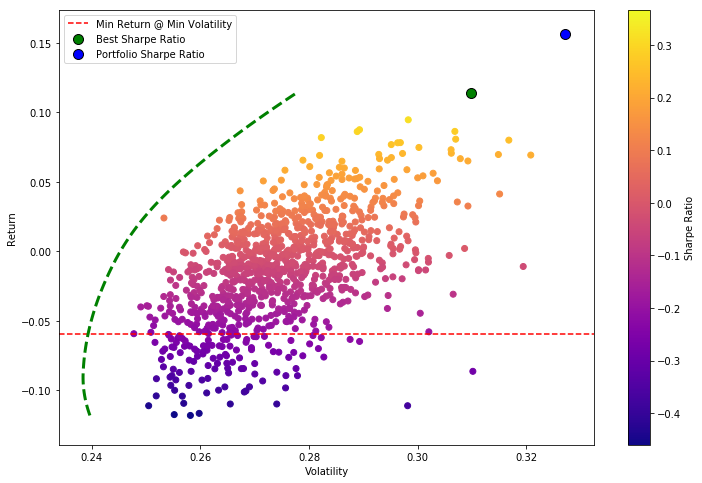

In [134]:
###    
# Plot the Monte Carlo to a scatterplot
efficient_frontier_fig = plt.figure(figsize=(12,8))
plt.scatter(expected_variance_arr, expected_returns_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add green dot for best SR
plt.scatter(best_variance, best_return, c='green', s=100, edgecolors='black', label='Best Sharpe Ratio')
# Add blue dot for current SR
plt.scatter(portfolio_expected_variance, portfolio_expected_returns, c='blue', s=100, edgecolors='black', label='Portfolio Sharpe Ratio')

# Add red line for least volatility
plt.axhline(y=min_return, color='r', linestyle='--', label='Min Return @ Min Volatility')
plt.legend()

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

## Green Line code ends

In [136]:
log_return.head()

Ticker,ABBV,ABMD,ADBE,ALSN,AMBA,AMCX,BIDU,CVS,G,OLED
Date,,,,,,,,,,
2015-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-27,NaN,NaN,NaN,NaN,0.026503,NaN,NaN,NaN,NaN,NaN
2015-03-30,NaN,NaN,NaN,NaN,0.058792,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,0.014636,NaN,NaN,NaN,NaN,NaN
2015-04-01,NaN,NaN,NaN,NaN,-0.023251,NaN,NaN,NaN,NaN,NaN


In [137]:
weight_stock_index

Index(['ABBV', 'ABMD', 'ADBE', 'ALSN', 'AMBA', 'AMCX', 'BIDU', 'CVS', 'G',
       'OLED'],
      dtype='object', name='Ticker')

In [138]:
portfolio_weights

array([0.10872021, 0.0734985 , 0.13437554, 0.06367682, 0.        ,
       0.03373486, 0.03496081, 0.07706205, 0.08385812, 0.39011309])

In [139]:
portfolio_expected_returns

0.15633222022953974

In [140]:
portfolio_expected_variance

0.3272084571560212

In [141]:
portfolio_sharpe_ratio

0.47777561004481195

In [142]:
best_sharpe_ratio

0.3666639221175

In [143]:
best_sharpe_ratio_weights

array([0.06281154, 0.04098427, 0.13621765, 0.02200526, 0.04825631,
       0.05135504, 0.06787043, 0.02424239, 0.30988193, 0.23637518])

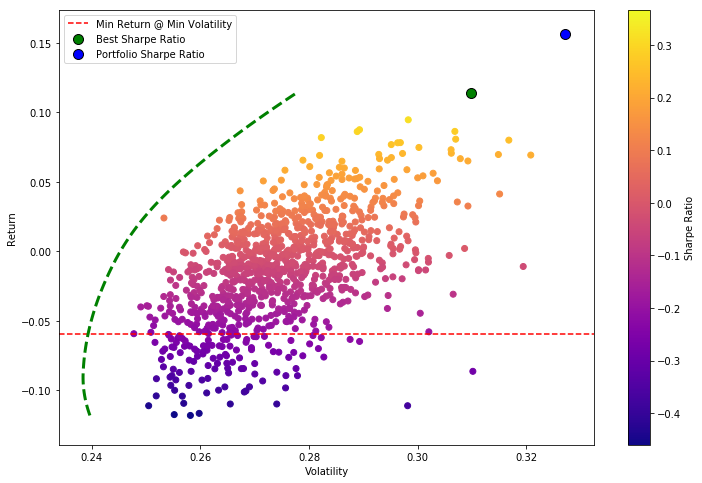

In [144]:
efficient_frontier_fig

### Function log_return_histogram
* Input
    * log_return
* Output
    * Histogram

In [145]:
# Create Histogram Plot

def log_return_histogram(df):
    df.hist(bins=100, figsize=(12,6))
    plt.tight_layout()

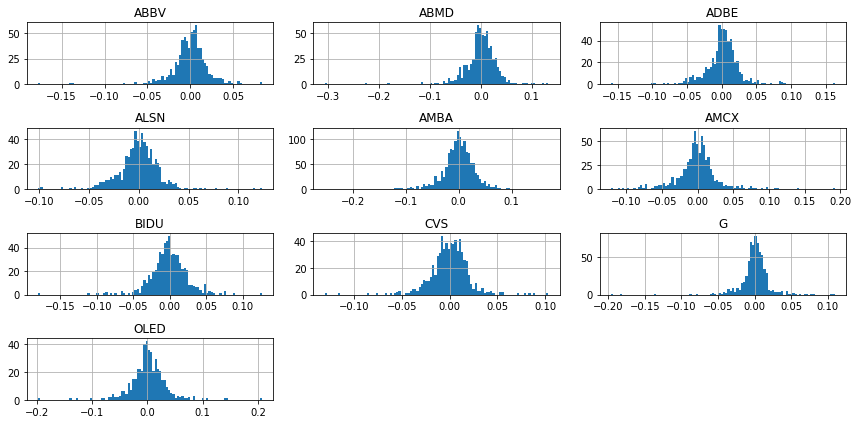

In [146]:
# Save Histograms to a variable
log_return_plot = log_return_histogram(log_return)

In [147]:
# Portfolio Projections

In [148]:
balance = total_balance
contribution = int(input("\nHow much money do you want to contribute per year?"))
years = int(input("\nHow many years do you want to project into the future?"))
mu = portfolio_expected_returns
sigma = portfolio_expected_variance
monte_runs = 1000


How much money do you want to contribute per year? 2000

How many years do you want to project into the future? 3


In [149]:
def portfolio_projection (starting_balance, yearly_contribution, num_of_years, mean, std_dev):
    balance_projection = starting_balance
    projection_list = []
    for i in range(num_of_years):
        yrly_rtn = random.gauss(mean, std_dev)
        balance_projection = (balance_projection + yearly_contribution)*(1 + yrly_rtn)
        projection_list.append(balance_projection)
    return projection_list

In [150]:
def monte_portfolio_projection (starting_balance, yearly_contribution, num_of_years, mean, std_dev, num_of_iterations):
    projection_list = []
    for i in range(num_of_iterations):
        iteration = portfolio_projection(starting_balance, yearly_contribution, num_of_years, mean, std_dev)
        projection_list.append(iteration)
    return projection_list

In [151]:
result = monte_portfolio_projection(balance, contribution, years, mu, sigma, monte_runs)


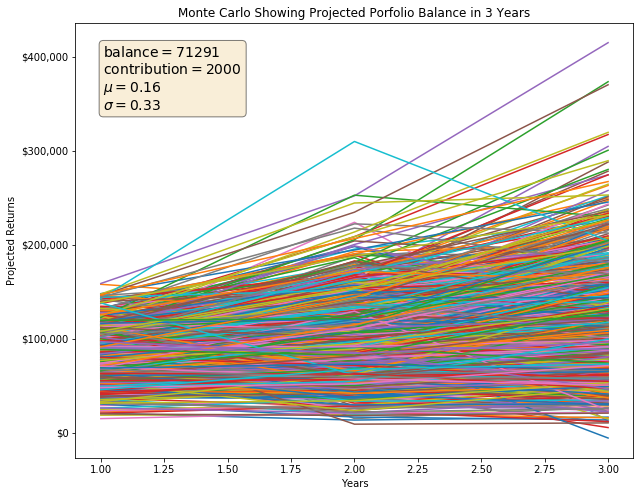

In [152]:
future_projection_fig, ax = plt.subplots(figsize=(10,8))
plt.xlabel("Years")
plt.ylabel("Projected Returns")
plt.title(f"Monte Carlo Showing Projected Porfolio Balance in {years} Years")

textstr = '\n'.join((
    r'$\mathrm{balance}=%.0f$' % (balance, ),
    r'$\mathrm{contribution}=%.0f$' % (contribution, ),
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))

for i in range(monte_runs):
    plt.plot([i+1 for i in range(len(result[0]))],[result[i][j] for j in range(len(result[0]))])

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.show()

# Plots

### Function stock_value_plot
* Input
    * portfolio4_df
* Output
    * Returns Plot

In [153]:
# Create Returns Plot

def stock_value_plot(df):
    return df.hvplot.line(
        x="Date",
        y="Daily Balance",
        groupby= "Ticker").opts(title="Portfolio Stock Value")


In [154]:
stock_value_plot(portfolio4_df)

:DynamicMap   [Ticker]
   :Curve   [Date]   (Daily Balance)

### Function pct_change_plot
* Input:
    * portfolio_df_returns4 or portfolio_df_returns2: Returns dataframe
* Output
    * Returns plot

In [155]:
# Create Percentage Change Plot

def pct_change_plot(df):
    return df.hvplot(
        x="Date",
#         y="Returns",
#         groupby= "Ticker"
        ).opts(title="Returns Daily Percent Change")

In [156]:
pct_change_plot(portfolio_df_returns4)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [157]:
pct_change_plot(portfolio_df_returns2)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# Panel Dashboard

Combine all of the charts into a single dashboard view using Panel.

In [158]:
# Assign Content to dashboard

ticker_performance=pn.Column(stock_value_plot(portfolio4_df), pct_change_plot(portfolio_df_returns2))
industry_analysis=pn.Row(industry_contribution_pie(industry_holdings), industry_value_pie(industry_holdings))
sector_analysis=pn.Row(sector_contribution_pie(sector_holdings), sector_value_pie(sector_holdings))
combo_analysis=pn.Column(industry_analysis, sector_analysis)
current_holdings=pn.Row(holdings_contribution_pie(current_industry_holdings), holdings_value_pie(current_industry_holdings))
ticker_histogram=pn.panel(log_return_plot)
efficient_frontier=pn.panel(efficient_frontier_fig)
future_projections=pn.panel(future_projection_fig)


In [159]:
# Create the Tabs

dashboard=pn.Tabs(("Ticker Performance", ticker_performance),
                  ("Current Holdings", current_holdings),
                  ("Industry & Sector Analysis", combo_analysis),
                  ("Ticker Histogram", ticker_histogram),
                  ("Ticker Stats", stats_panel),
                  ("Efficient Frontier", efficient_frontier),
                  ("Future Projections", future_projections)
                 )


Tabs
    [0] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Ticker', options=['AMBA', 'ABBV', ...], value='AMBA', width=250)
                [1] VSpacer()
        [1] HoloViews(NdOverlay)
    [1] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [2] Column
        [0] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [1] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
    [3] Str(None)
    [4] HTML(Styler)
    [5] Matplotlib(Figure)
    [6] Matplotlib(Figure)
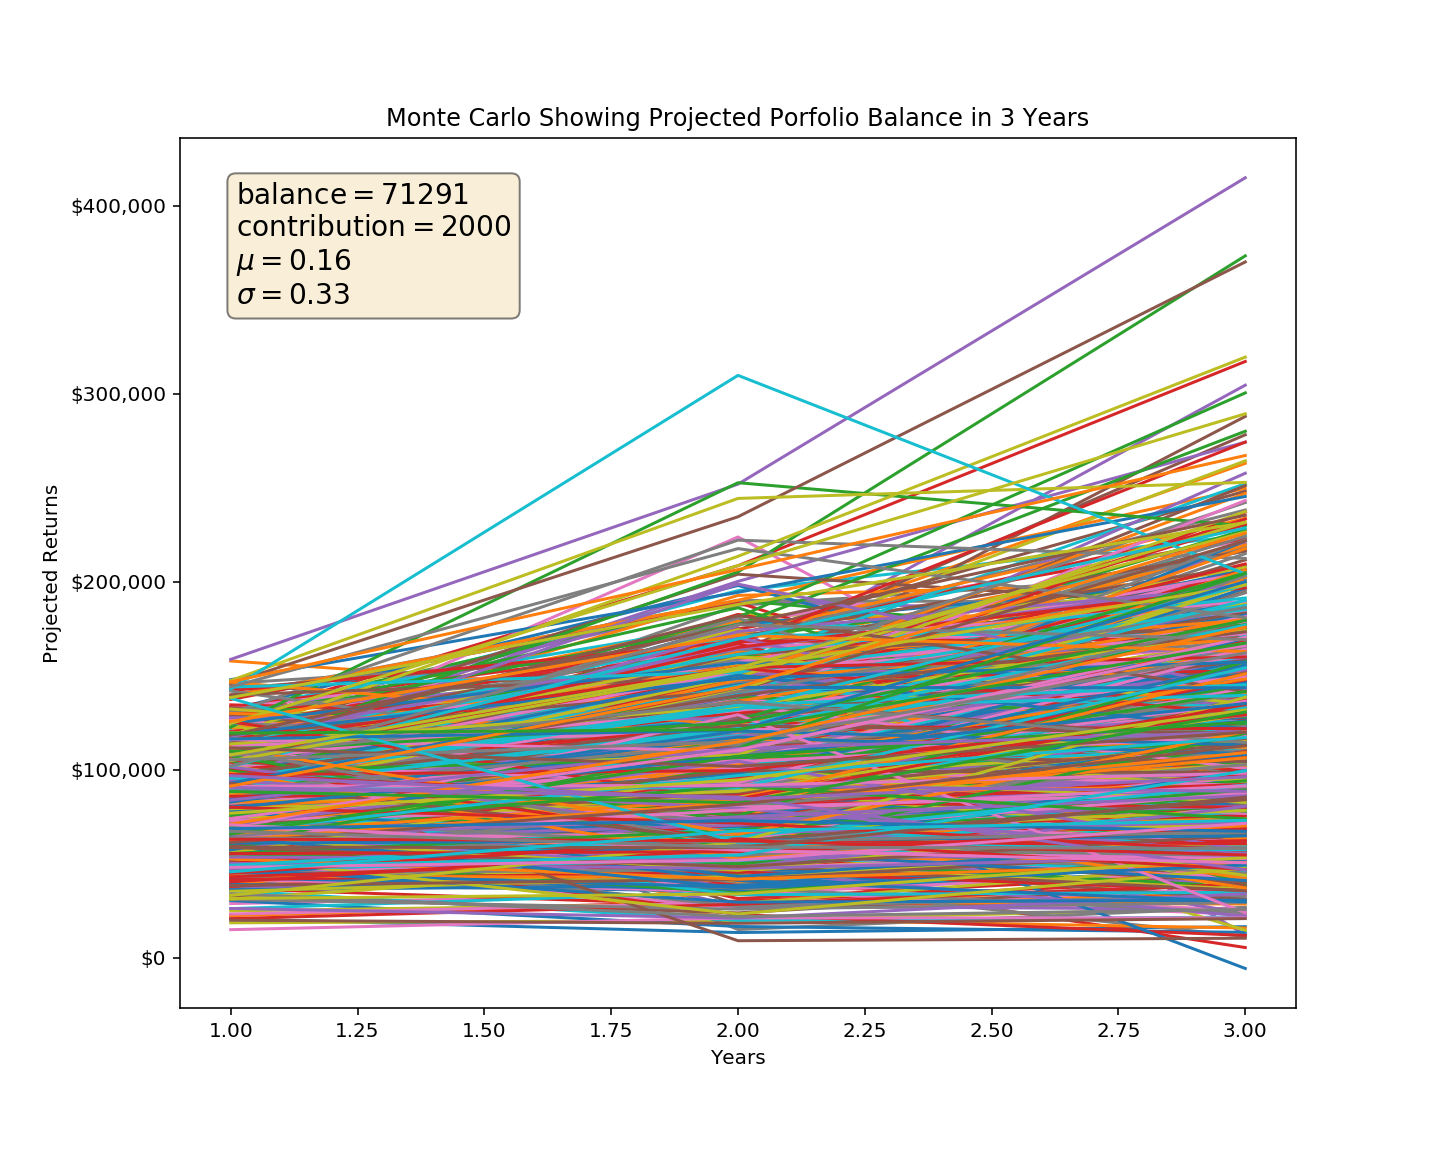
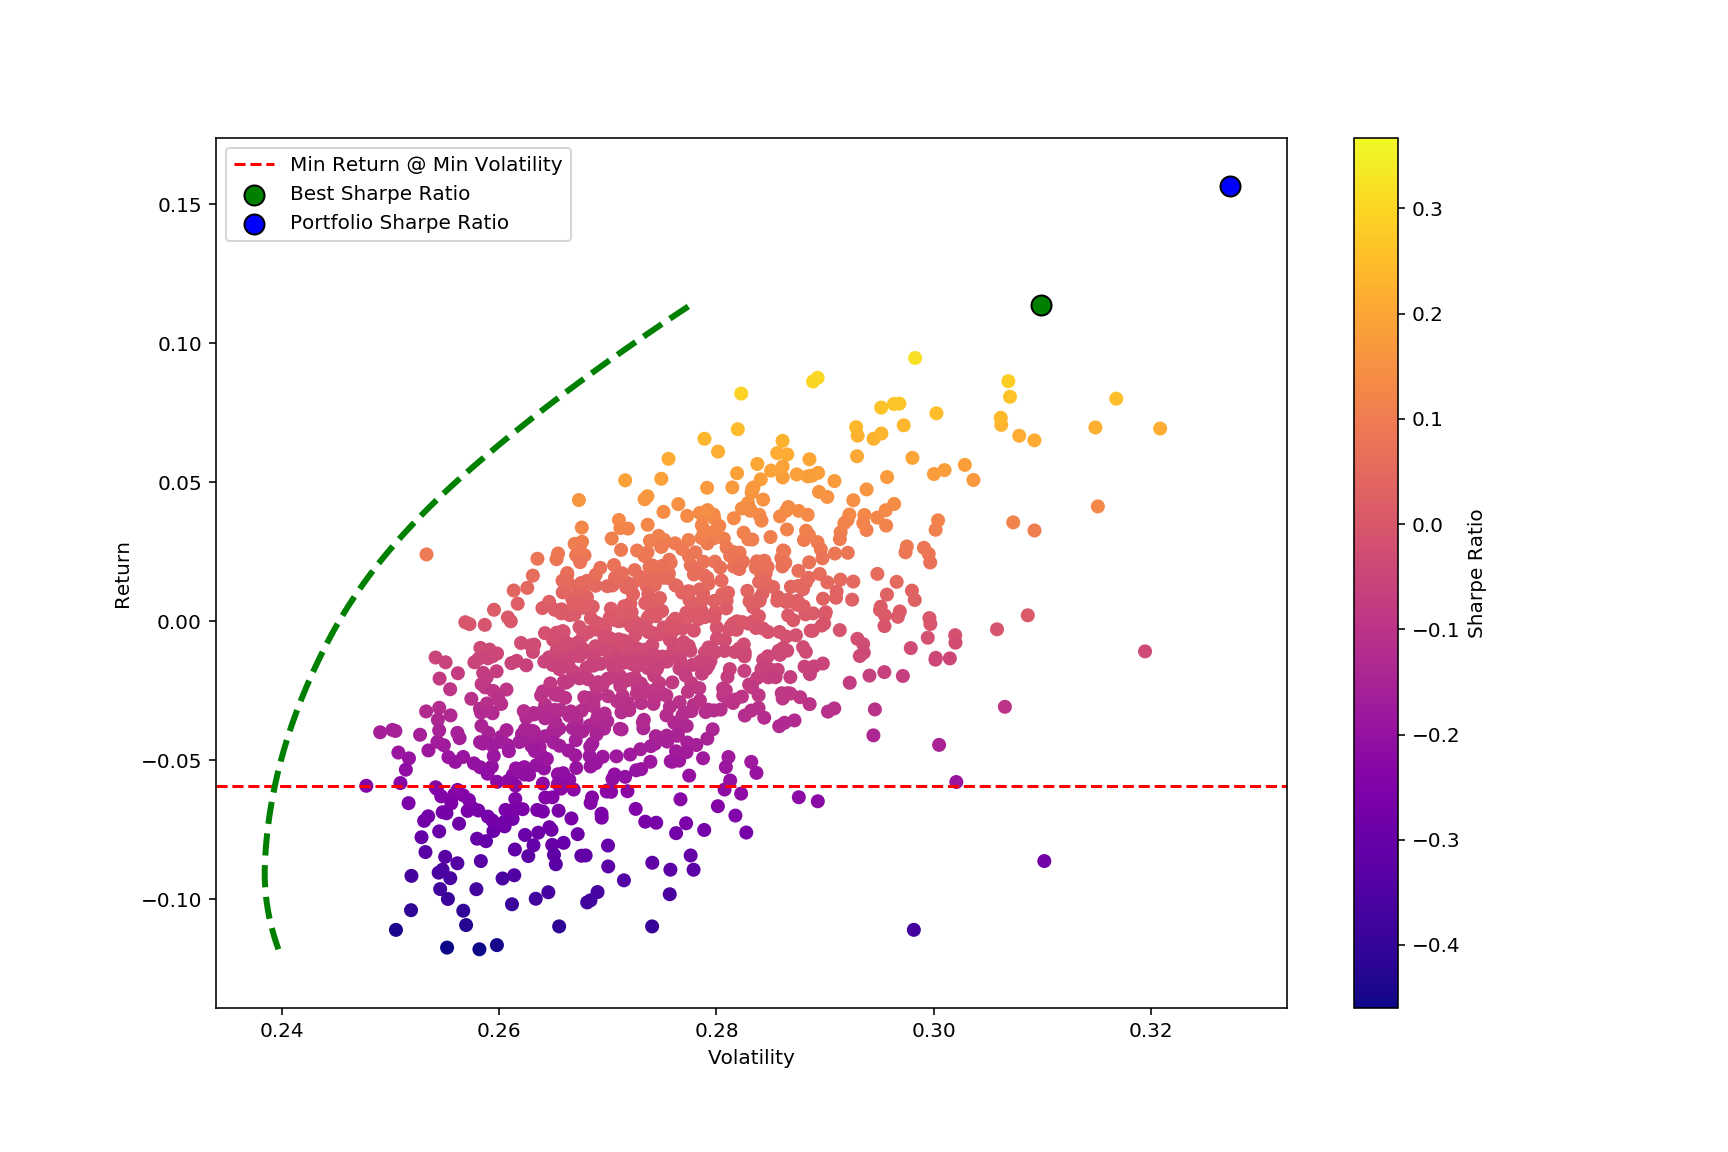

In [160]:
# Serve the Panel Dashboard

dashboard.servable()

# Robo Code

In [161]:
def get_closing_price (ticker):
    stock_info = yf.Ticker(ticker)

    # get historical market data
    hist = stock_info.history(period="max")
    hist2=hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
    return hist2

In [162]:
print(f"Congratulations on taking an interest in improving your results! Based on your current portfolio, your Sharpe Ratio is {portfolio_sharpe_ratio:.2f}.  The Sharpe Ratio is the best way to measure your risk-adjusted return.  The higher the Sharpe Ratio, the higher the returns and the sooner you can retire!")


Congratulations on taking an interest in improving your results! Based on your current portfolio, your Sharpe Ratio is 0.48.  The Sharpe Ratio is the best way to measure your risk-adjusted return.  The higher the Sharpe Ratio, the higher the returns and the sooner you can retire!


In [166]:
print(f"Based on a theoretical analysis of your portfolio, the most optimal Sharpe Ratio is {best_sharpe_ratio:.2f}. Keep in mind, it may not be possible to obtain this Sharpe Ratio based on the random nature of the market, but there are proven ways to help improve the portfolio's Sharpe Ratio.")
ui_improve = input ("\nWould you like to try to improve your portfolio? (Yes or No)")


Based on a theoretical analysis of your portfolio, the most optimal Sharpe Ratio is 0.37. Keep in mind, it may not be possible to obtain this Sharpe Ratio based on the random nature of the market, but there are proven ways to help improve the portfolio's Sharpe Ratio.



Would you like to try to improve your portfolio? (Yes or No) Yes


In [167]:
# Define empty lists for user inputs
add_list = []
remove_list = []

In [169]:
# Enter if user wants to improve portfolio
if (ui_improve.lower() == "yes" or ui_improve.lower() == "y"):
    print("Great! Let's get started! I will ask you a series of questions to help modify your portfolio to see if we can improve your performance.")
    print("\nThere's a few things to keep in mind.")
    print("\t* Rule 1")

    # Ask if user wants to keep/add/remove stocks
    ui_stock_change = input ("\nAre you satisfied with you current mix of stocks or would you like to add or remove stocks? (keep, add, remove)")
 

    # Enter if user wants to add stocks
    if (ui_stock_change.lower() == "add"):
        ui_stock_add_num = input ("\nHow many stocks would you like to add to your portfolio?")
        print(f"Great! We'll add the {ui_stock_add_num} stocks one at a time.")
        
        # Loop to gather ticker, investment $, and purchase date for each ticker
        for i in range(int(ui_stock_add_num)):
            ui_stock_add_tckr = input (f"\nWhat is the ticker for Stock {i+1} that you want to add?")
            stock_add_tckr = ui_stock_add_tckr.upper()
          
            ui_stock_add_date = input (f"\nWhat day do you want to buy {stock_add_tckr}? (MM/DD/YYYY)")
            stock_add_date = datetime.strptime(ui_stock_add_date, '%m/%d/%Y').date()

            #Grab closing price data
            stock_add_closing_df = get_closing_price(stock_add_tckr)
            stock_add_closing_price = stock_add_closing_df.loc[stock_add_date]["Close"]            
            
            ui_stock_add_cost = input (f"\nFor the analysis, we'll assume only the inital purchase as the full investment. How much would you like to invest in {stock_add_tckr}? $")
            stock_add_cost = ui_stock_add_cost.replace(',','')
            
            #Calculate number of shares
            stock_add_num_shares = round(int(stock_add_cost) / int(stock_add_closing_price), 0)
            
            add_list.append([stock_add_date, stock_add_tckr, "B", stock_add_closing_price, stock_add_num_shares, stock_add_cost])
 

    # Enter if user wants to remove stocks
    elif (ui_stock_change.lower() == "remove"):
        ui_stock_remove_num = input ("\nHow many stocks would you like to remove from your portfolio?")
        
        # Loop to gather all tickers to remove from portfolio
        for i in range(int(ui_stock_remove_num)):
            ui_stock_remove_tckr = input (f"\nWhat is the ticker for Stock {i+1} that you want to remove?")
            stock_remove_tckr = ui_stock_remove_tckr.upper()
            print(f"{stock_remove_tckr} will be removed from your portfolio.")
            remove_list.append(stock_remove_tckr)
   

    # Enter if user does not want to add or remove stocks
    else:
        print(f"\nOkay, we won't change your mix of stocks.  Your stocks will remain: \n{stock_list}")

        
# Enter if user does not want to improve portflio.    
else:
    print("If you change your mind, let me know.")

Great! Let's get started! I will ask you a series of questions to help modify your portfolio to see if we can improve your performance.

There's a few things to keep in mind.
	* Rule 1



Are you satisfied with you current mix of stocks or would you like to add or remove stocks? (keep, add, remove) cgc



Okay, we won't change your mix of stocks.  Your stocks will remain: 
['ABBV', 'ABMD', 'ADBE', 'ALSN', 'AMBA', 'AMCX', 'BIDU', 'CVS', 'G', 'OLED']


In [170]:
add_list

[]

In [ ]:
remove_list

In [171]:
def create_new_transaction_df (add_list, remove_list, starting_df):
    # Remove unwanted tickers from starting_df
    for i in range(len(remove_list)):
        starting_df.drop(starting_df.loc[starting_df['Ticker']==remove_list[i]].index, inplace=True)
    
    # Create dataframe of new transactions in add_list
    # Store column names from starting df in list
    df = starting_df.reset_index()
    column_names=list(df.columns)
    
    # Convert add_list to a df
    user_inputs_df = pd.DataFrame(add_list, columns=column_names)
    
    # Convert Date to datetime and set as index
    user_inputs_df['Date']=pd.to_datetime(user_inputs_df['Date'])
    user_inputs_df.set_index(['Date'], inplace=True)
    
    # Concatenate new dataframe with starting dataframe 
    new_trans_df = pd.concat([starting_df, user_inputs_df])
    
    return new_trans_df

In [172]:
test = create_new_transaction_df(add_list, remove_list, trans_df)
test

,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
Date,,,,,
2015-03-26,AMBA,B,67.90,70,4753.00
2018-01-29,AMBA,S,48.51,70,3395.70
2018-01-29,ALSN,B,39.26,130,5103.80
2018-01-29,CVS,B,82.00,60,4920.00
2018-01-29,ABBV,B,121.37,40,4854.80
2018-01-29,AMCX,B,52.99,100,5299.00
2018-02-28,G,B,31.90,155,4944.50
2018-02-28,ABMD,B,270.52,20,5410.40
2018-02-28,BIDU,B,251.34,20,5026.80


In [173]:
new_portfolio_df = calc_basic_transaction_data(test.copy())
new_portfolio_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Proceeds,Cumulative Shares,Cumulative Contributions,Avg Price per Share
0,2018-01-29,ABBV,B,121.37,40,4854.80,0.0,40,4854.80,121.370000
1,2018-05-29,ABBV,B,100.20,50,5010.00,0.0,90,9864.80,109.608889
2,2019-03-19,ABBV,S,79.93,-90,-9864.80,7193.7,0,0.00,NaN
3,2018-02-28,ABMD,B,270.52,20,5410.40,0.0,20,5410.40,270.520000
4,2018-05-29,ADBE,B,242.77,20,4855.40,0.0,20,4855.40,242.770000
5,2018-01-29,ALSN,B,39.26,130,5103.80,0.0,130,5103.80,39.260000
6,2015-03-26,AMBA,B,67.90,70,4753.00,0.0,70,4753.00,67.900000
7,2018-01-29,AMBA,S,48.51,-70,-4753.00,3395.7,0,0.00,NaN
8,2018-01-29,AMCX,B,52.99,100,5299.00,0.0,100,5299.00,52.990000
9,2018-02-28,BIDU,B,251.34,20,5026.80,0.0,20,5026.80,251.340000
